In [1]:
#import os
#os.chdir("Applied Data Science\project2\code")
#os.getcwd()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from scipy.special import boxcox, inv_boxcox
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder

In [3]:
true = pd.read_feather('data/test.feather')['revenue']
true

0           77.658537
1           56.962025
2           68.051613
3           44.904652
4           63.636364
              ...    
4335200     74.925000
4335201    103.125000
4335202     55.851429
4335203     52.144330
4335204     58.417850
Name: revenue, Length: 4335205, dtype: float64

In [4]:
pred_linear = pd.read_csv('data/test_output.csv')['predict']

In [5]:
_lambda = pd.read_csv("data/lambda_list.csv")
_lambda

,Unnamed: 0,trip_distance,fare_amount,tip_amount,duration,revenue
0,0,-0.173857,-0.443243,0.462488,0.079021,-0.681852


In [6]:
pred_linear = inv_boxcox(pred_linear, -0.681852)
pred_linear.replace([np.inf, -np.inf], np.nan, inplace=True)
pred_linear.fillna(0, inplace=True)
pred_linear

0           83.191800
1           69.235895
2           58.060569
3           40.650461
4           75.237809
              ...    
4335200     66.445531
4335201    106.667851
4335202     56.513942
4335203     52.225508
4335204     79.904453
Name: predict, Length: 4335205, dtype: float64

In [7]:
scores = []
def store_score(scores, pred,true=true):
    curr = [r2_score(true, pred), mean_absolute_error(true, pred),
            mean_squared_error(true, pred)]
    scores.append(curr)

In [8]:
store_score(scores, pred_linear)

In [9]:
train = pd.read_feather('data/train_scaled.feather')
test = pd.read_feather('data/test_scaled.feather')

In [10]:
def preprocessing(df):
    df['passenger_count'] = df['passenger_count'].astype('category')
    df['start_hour'] = df['start_hour'].astype('category')
    df['day_of_week'] = df['day_of_week'].astype('category')
    df['weather'] = df['weather'].astype('category')
    x = df.drop(['fare_amount','revenue'], axis=1)
    x = pd.get_dummies(x)
    y = df['revenue']

    return x, y

In [11]:
train_x, train_y = preprocessing(train)
test_x, test_y = preprocessing(test)

In [12]:
model = XGBRegressor()
model.fit(train_x, train_y)
pred_xgboost = model.predict(test_x)

pred_xgboost = inv_boxcox(pred_xgboost, -0.681852)

In [13]:
pred_xgboost[np.isnan(pred_xgboost)]=0
store_score(scores, pred_xgboost)

In [14]:
mean = [true.mean()] * len(true)
store_score(scores, mean)

In [15]:
median = [true.median()] * len(true)
store_score(scores, median)

In [16]:
scores

[[0.6312128067940872, 7.646990861198339, 170.69201589626869],
 [0.9892818371805583, 1.577627790537623, 4.960868631176782],
 [0.0, 15.833505114833216, 462.8469183336379],
 [-0.05454166382931325, 15.27506086086051, 488.0913593578248]]

# how the duration and trip distance change the revenue

In [17]:
x=np.arange(1.35,1.45,0.01)
y= inv_boxcox(x, -0.681852)
y

array([ 40.99364064,  46.75528888,  54.02260299,  63.41376774,
        75.91767435,  93.20789982, 118.32848055, 157.37264446,
       224.28732237, 358.19011555])

In [18]:
distance = inv_boxcox(x+0.07672, -0.681852) - inv_boxcox(x, -0.681852)
distance

array([ 156.76256084,  255.26502818,  495.05783271, 1468.30202033,
                 nan,           nan,           nan,           nan,
                 nan,           nan])

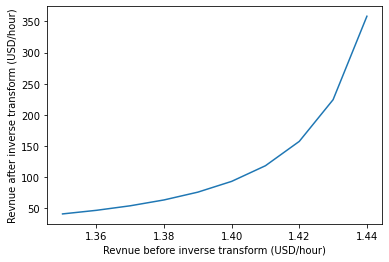

In [19]:
import matplotlib.pyplot as plt
plt.xlabel('Revnue before inverse transform (USD/hour)')
plt.ylabel("Revnue after inverse transform (USD/hour)")
plt.plot(x,y)